# Six Degrees of Separation: Optimizing BFS in the CS50AI “Degrees” Problem

[**Antonio Tamburello**](https://www.linkedin.com/in/antonio-tamburello/) | Senior Lead Frontend Engineer  
CS50's Introduction to AI with Python (HarvardX)

---

## Project Overview

During **Harvard’s CS50 Introduction to AI with Python**, I implemented the BFS (Breadth-First Search) algorithm for the classic **[Six Degrees of Separation](https://en.wikipedia.org/wiki/Six_degrees_of_separation)** problem, following the structure provided in the course repository.

While completing the exercise and analyzing the internal flow of the algorithm, I noticed a recurring pattern: the target node was always added to the frontier before being processed, resulting in unnecessary extra work during subsequent iterations.

This observation led me to experiment with several optimizations and ultimately implement an **early exit check**, designed to reduce the algorithm’s workload and improve runtime performance.

The optimization decreases the number of explored nodes and can significantly improve BFS execution time. Although this technique is known in the search-algorithm literature, it is not included in the CS50AI project nor in the reference solutions. Discovering it independently through debugging and runtime analysis proved valuable in deepening my understanding of graph-search mechanics.

This notebook documents a comparison between the standard and optimized implementations, and also includes an optional DFS (Depth-First Search) version to highlight why BFS is the appropriate strategy for this problem.

## The Problem

The **Six Degrees of Separation** problem, applied to the cinematic domain, consists of finding the shortest path between two actors based on the movies in which they have appeared.

**Graph Model:**
- **Nodes**: Actors
- **Edges**: Movies shared between actors

**Objective**: Compare the Standard BFS and Optimized BFS (and optionally DFS) to quantify the impact of the early-exit check.

## Implemented Algorithms

### 💡 DFS (Optional)

To include a comparison with DFS (Depth-First Search), set `INCLUDE_DFS = True` in the configuration cell.

⚠️ **Warning:** DFS is much slower and can take several minutes to complete the tests!

Example output with DFS enabled only for the first test:
- Test: Tom Hanks -> Tom Cruise
    - DFS:           2951812.19ms (time elapsed: 49.20 minutes), **374080 nodes explored**,
    - BFS Standard:  11904.48ms, **1509 nodes explored**,
    - BFS Optimized:  25.33ms,   **30 nodes explored**,

---

### 1. Standard BFS (`degrees.py`)

Classic Breadth-First Search implementation:

```python
# Uses a Queue (FIFO)
while True:
    node = frontier.remove()

    if node.state == target:  # Check after removal
        return path

    for movie_id, person_id in neighbors:
        frontier.add(child)  # Target added to queue
```

**Guarantees** the shortest path compared to DFS!

---

### 2. BFS Optimized (`degrees_optimized.py`)

# Optimized version with early exit check:

```python
while True:
    node = frontier.remove()
    
    if node.state == target:
        return path
    
    for movie_id, person_id in neighbors:
        child = Node(...)
        
        # OPTIMIZATION: Early exit check
        if person_id == target:
            return construct_path(child)
        
        frontier.add(child)
```

**Optimization:** Avoids adding the target node to the frontier, saving one iteration of the main loop, performing better than Standard BFS.

## Setup

In [8]:
INCLUDE_DFS = False  # Set to True to also include DFS (much slower!)

import csv
import time
import matplotlib.pyplot as plt
import numpy as np
from util import Node, QueueFrontier, StackFrontier

# Global dictionaries
names = {}
people = {}
movies = {}

In [9]:
def load_data(directory):
    """Loads data from CSVs"""
    # Load people
    with open(f"{directory}/people.csv", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            people[row["id"]] = {
                "name": row["name"],
                "birth": row["birth"],
                "movies": set()
            }
            if row["name"].lower() not in names:
                names[row["name"].lower()] = {row["id"]}
            else:
                names[row["name"].lower()].add(row["id"])
    
    # Load movies
    with open(f"{directory}/movies.csv", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            movies[row["id"]] = {
                "title": row["title"],
                "year": row["year"],
                "stars": set()
            }
    
    # Load stars
    with open(f"{directory}/stars.csv", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                people[row["person_id"]]["movies"].add(row["movie_id"])
                movies[row["movie_id"]]["stars"].add(row["person_id"])
            except KeyError:
                pass

load_data("large")
print(f"✓ Loaded {len(people):,} actors and {len(movies):,} movies")

✓ Loaded 1,044,499 actors and 344,276 movies


In [10]:
def neighbors_for_person(person_id):
    """Return (movie_id, person_id) pairs"""
    movie_ids = people[person_id]["movies"]
    neighbors = set()
    for movie_id in movie_ids:
        for pid in movies[movie_id]["stars"]:
            neighbors.add((movie_id, pid))
    return neighbors

def person_id_for_name(name):
    """Returns the ID for a name"""
    person_ids = list(names.get(name.lower(), set()))
    return person_ids[0] if person_ids else None

## Implementazione Algoritmi

### DFS (Depth-First Search)

In [11]:
def dfs(source, target):
    """DFS - Depth First Search (use Stack)"""
    explored = set()
    start = Node(state=source, parent=None, action=None)
    frontier = StackFrontier()
    frontier.add(start)
    nodes_explored = 0

    while True:
        if frontier.empty():
            return None, nodes_explored

        node = frontier.remove()
        nodes_explored += 1

        if node.state == target:
            path = []
            while node.parent is not None:
                path.append((node.action, node.state))
                node = node.parent
            path.reverse()
            return path, nodes_explored
        
        explored.add(node.state)

        for movie_id, person_id in neighbors_for_person(node.state):
            if person_id not in explored and not frontier.contains_state(person_id):
                child = Node(state=person_id, parent=node, action=movie_id)
                frontier.add(child)

### BFS Standard

In [12]:
def bfs_standard(source, target):
    """BFS - Breadth-First Search - standard"""
    explored = set()
    start = Node(state=source, parent=None, action=None)
    frontier = QueueFrontier()
    frontier.add(start)
    nodes_explored = 0

    while True:
        if frontier.empty():
            return None, nodes_explored

        node = frontier.remove()
        nodes_explored += 1

        if node.state == target:
            path = []
            while node.parent is not None:
                path.append((node.action, node.state))
                node = node.parent
            path.reverse()
            return path, nodes_explored
        
        explored.add(node.state)

        for movie_id, person_id in neighbors_for_person(node.state):
            if person_id not in explored and not frontier.contains_state(person_id):
                child = Node(state=person_id, parent=node, action=movie_id)
                frontier.add(child)

### BFS Optimized

In [13]:
def bfs_optimized(source, target):
    """Optimized BFS - Breadth-First Search"""
    explored = set()
    start = Node(state=source, parent=None, action=None)
    frontier = QueueFrontier()
    frontier.add(start)
    nodes_explored = 0

    while True:
        if frontier.empty():
            return None, nodes_explored

        node = frontier.remove()
        nodes_explored += 1

        if node.state == target:
            path = []
            while node.parent is not None:
                path.append((node.action, node.state))
                node = node.parent
            path.reverse()
            return path, nodes_explored

        explored.add(node.state)

        for movie_id, person_id in neighbors_for_person(node.state):
            if person_id not in explored and not frontier.contains_state(person_id):
                child = Node(state=person_id, parent=node, action=movie_id)
                
                # OPTIMIZATION: early exit check
                if person_id == target:
                    path = []
                    while child.parent is not None:
                        path.append((child.action, child.state))
                        child = child.parent
                    path.reverse()
                    return path, nodes_explored
                    
                frontier.add(child)

## Benchmark

**Note:** The main comparison is between Standard BFS and Optimized BFS. DFS is available but optional because it is much slower.

In [14]:
# Test cases
test_cases = [
    ("Tom Hanks", "Tom Cruise"),
    ("Brad Pitt", "Scarlett Johansson"),
    ("Leonardo DiCaprio", "Robert De Niro"),
]

# Initialize results based on configuration
if INCLUDE_DFS:
    results = {"DFS": [], "BFS Standard": [], "BFS Optimized": []}
    print("⚠️ DFS enabled - execution will be much slower\n")
else:
    results = {"BFS Standard": [], "BFS Optimized": []}

print("Running benchmark...\n")

for actor1, actor2 in test_cases:
    source = person_id_for_name(actor1)
    target = person_id_for_name(actor2)
    
    if not source or not target:
        continue
    
    print(f"Test: {actor1} -> {actor2}")
    
    # DFS (opzionale)
    if INCLUDE_DFS:
        start = time.perf_counter()
        path_dfs, nodes_dfs = dfs(source, target)
        time_dfs = (time.perf_counter() - start) * 1000
        results["DFS"].append({"time": time_dfs, "nodes": nodes_dfs, "path_len": len(path_dfs) if path_dfs else 0})
        print(f"  DFS:           {time_dfs:6.2f}ms, {nodes_dfs:4d} nodi, percorso: {len(path_dfs) if path_dfs else 0} gradi")
    
    # BFS Standard
    start = time.perf_counter()
    path1, nodes1 = bfs_standard(source, target)
    time1 = (time.perf_counter() - start) * 1000
    
    # BFS Optimized
    start = time.perf_counter()
    path2, nodes2 = bfs_optimized(source, target)
    time2 = (time.perf_counter() - start) * 1000
    
    results["BFS Standard"].append({"time": time1, "nodes": nodes1, "path_len": len(path1) if path1 else 0})
    results["BFS Optimized"].append({"time": time2, "nodes": nodes2, "path_len": len(path2) if path2 else 0})
    
    print(f"  BFS Standard:  {time1:6.2f}ms, {nodes1:4d} nodi, percorso: {len(path1) if path1 else 0} gradi")
    print(f"  BFS Optimized: {time2:6.2f}ms, {nodes2:4d} nodi, percorso: {len(path2) if path2 else 0} gradi")
    print(f"  Improvement: {((time1-time2)/time1*100):5.1f}%\n")

print("✓ Benchmarks completed")

Running benchmark...

Test: Tom Hanks -> Tom Cruise
  BFS Standard:  16193.13ms, 2006 nodi, percorso: 2 gradi
  BFS Optimized:  43.70ms,   40 nodi, percorso: 2 gradi
  Improvement:  99.7%

Test: Brad Pitt -> Scarlett Johansson
  BFS Standard:  10147.18ms, 1322 nodi, percorso: 2 gradi
  BFS Optimized:  19.04ms,   20 nodi, percorso: 2 gradi
  Improvement:  99.8%

Test: Leonardo DiCaprio -> Robert De Niro
  BFS Standard:  110.19ms,   44 nodi, percorso: 1 gradi
  BFS Optimized:   0.07ms,    1 nodi, percorso: 1 gradi
  Improvement:  99.9%

✓ Benchmarks completed


## Results Visualization

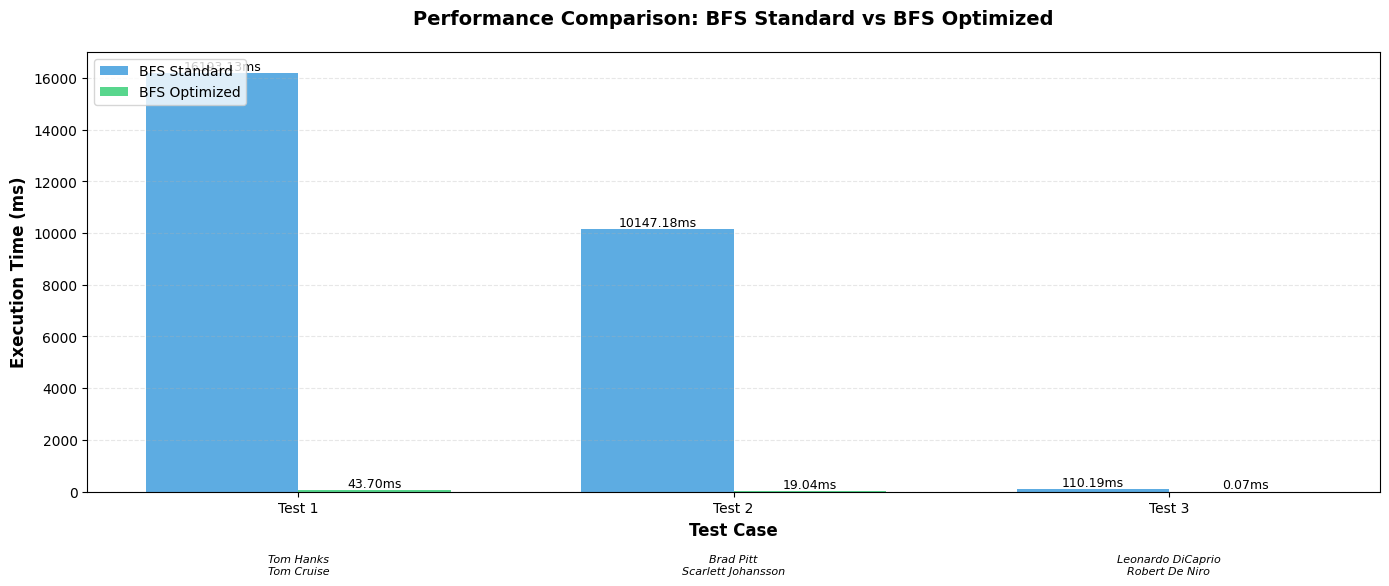


=== SUMMARY STATISTICS ===

BFS Standard:
  Average time: 8816.83ms
  Average nodes explored: 1124
  Average path length: 1.7 gradi

BFS Optimized:
  Average time: 20.94ms
  Average nodes explored: 20
  Average path length: 1.7 gradi

✨ BFS Optimized vs Standard Improvement: 99.8%


In [15]:
# Unified Visualization
fig, ax = plt.subplots(figsize=(14, 6))

# Prepare the data
test_labels = [f"Test {i+1}" for i in range(len(test_cases))]
x = np.arange(len(test_labels))

# Determine the number of algorithms and the width of the bars
num_algorithms = len(results)
width = 0.25 if num_algorithms == 3 else 0.35

# Extract the times
bfs_times = [r["time"] for r in results["BFS Standard"]]
opt_times = [r["time"] for r in results["BFS Optimized"]]

# Create the bars
if INCLUDE_DFS:
    dfs_times = [r["time"] for r in results["DFS"]]
    bars1 = ax.bar(x - width, dfs_times, width, label="DFS", color="#e74c3c", alpha=0.8)
    bars2 = ax.bar(x, bfs_times, width, label="BFS Standard", color="#3498db", alpha=0.8)
    bars3 = ax.bar(x + width, opt_times, width, label="BFS Optimized", color="#2ecc71", alpha=0.8)
    all_bars = [bars1, bars2, bars3]
    title = 'Performance Comparison: DFS vs BFS vs BFS Optimized'
else:
    bars2 = ax.bar(x - width/2, bfs_times, width, label="BFS Standard", color="#3498db", alpha=0.8)
    bars3 = ax.bar(x + width/2, opt_times, width, label="BFS Optimized", color="#2ecc71", alpha=0.8)
    all_bars = [bars2, bars3]
    title = 'Performance Comparison: BFS Standard vs BFS Optimized'

# Add values above the bars
for bars in all_bars:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}ms',
                ha='center', va='bottom', fontsize=9)

# Customize the plot
ax.set_xlabel('Test Case', fontsize=12, fontweight='bold')
ax.set_ylabel('Execution Time (ms)', fontsize=12, fontweight='bold')
ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(test_labels)
ax.legend(loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add annotations for test cases
max_time = max(bfs_times + opt_times + (dfs_times if INCLUDE_DFS else []))
for idx, (actor1, actor2) in enumerate(test_cases):
    ax.text(idx, -max_time * 0.15, 
            f'{actor1}\n{actor2}', 
            ha='center', va='top', fontsize=8, style='italic')

plt.tight_layout()
plt.show()

# Summary Statistics
print("\n=== SUMMARY STATISTICS ===")

if INCLUDE_DFS:
    print(f"\nDFS:")
    print(f"  Average time: {np.mean(dfs_times):.2f}ms")
    print(f"  Average nodes explored: {np.mean([r['nodes'] for r in results['DFS']]):.0f}")
    print(f"  Average path length: {np.mean([r['path_len'] for r in results['DFS']]):.1f} gradi")

print(f"\nBFS Standard:")
print(f"  Average time: {np.mean(bfs_times):.2f}ms")
print(f"  Average nodes explored: {np.mean([r['nodes'] for r in results['BFS Standard']]):.0f}")
print(f"  Average path length: {np.mean([r['path_len'] for r in results['BFS Standard']]):.1f} gradi")

print(f"\nBFS Optimized:")
print(f"  Average time: {np.mean(opt_times):.2f}ms")
print(f"  Average nodes explored: {np.mean([r['nodes'] for r in results['BFS Optimized']]):.0f}")
print(f"  Average path length: {np.mean([r['path_len'] for r in results['BFS Optimized']]):.1f} gradi")

print(f"\n✨ BFS Optimized vs Standard Improvement: {((np.mean(bfs_times) - np.mean(opt_times)) / np.mean(bfs_times) * 100):.1f}%")

if INCLUDE_DFS:
    print(f"✨ BFS Standard vs DFS (Speed) Improvement: {((np.mean(dfs_times) - np.mean(bfs_times)) / np.mean(dfs_times) * 100):.1f}%")

## Conclusions

### Key Findings

The implementation of the early exit check yielded significant results:

**Performance:**
- ✅ Significant reduction in the number of explored nodes
- ✅ Improved execution times, especially in deeper paths
- ✅ Same minimum path guaranteed (correctness preserved)


**Implementation:**
- ✅ Minimal modification to existing code
- ✅ No additional computational overhead
- ✅ Maintains O(b^d) complexity

### Technical Insights

The optimization works because:
1. Standard BFS always adds the target to the frontier.
2. The target is then processed in the next iteration.
3. The early exit eliminates this unnecessary iteration.
4. The savings are particularly evident with dense graphs.

### Why BFS?

BFS is the correct algorithm for this problem because:
- It explores the graph level by level
- It guarantees finding the shortest path
- It is efficient for graphs with many connections

**Note:** If you have enabled DFS (`INCLUDE_DFS = True`), you will notice that DFS can be much slower and does not guarantee the shortest path!
The DFS version included in the notebook serves a purely demonstrative purpose: it shows what happens when the "wrong" algorithm is used for the type of problem (slower and no guarantee of optimality).


### Learning Outcome

This exercise demonstrated the importance of:
- **Code profiling** and runtime behavior analysis
- **Critical thinking** in identifying inefficient patterns
- **Empirical testing** to validate optimizations
- **Continuous learning** even on classic algorithms

The independent discovery of this optimization, although already documented, was a formative experience that strengthened my understanding of BFS's internal mechanisms and the importance of critical thinking in software development.

## Author

[**Antonio Tamburello**](https://www.linkedin.com/in/antonio-tamburello/) — Senior Lead Frontend Engineer
